In [1]:
import tensorflow as tf



In [2]:
def img_scaler(image, max_dim = 256):
  # Casts a tensor to a new type.
  original_shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  # Creates a scale constant for the image
  scale_ratio = 4 * max_dim / max(original_shape)
  # Casts a tensor to a new type.
  new_shape = tf.cast(original_shape * scale_ratio, tf.int32)
  # Resizes the image based on the scaling constant generated above
  return tf.image.resize(image, new_shape)

In [3]:
def load_img(path_to_img):
  # Reads and outputs the entire contents of the input filename.
  img = tf.io.read_file(path_to_img)
  # Detect whether an image is a BMP, GIF, JPEG, or PNG, and 
  # performs the appropriate operation to convert the input 
  # bytes string into a Tensor of type dtype
  img = tf.image.decode_image(img, channels=3)
  # Convert image to dtype, scaling (MinMax Normalization) its values if needed.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Scale the image using the custom function we created
  img = img_scaler(img)
  # Adds a fourth dimension to the Tensor because
  # the model requires a 4-dimensional Tensor
  return img[tf.newaxis, :]

In [6]:

content_image = load_img("/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images2/photo_jpg/0a7b607c9c.jpg")
style_image = load_img("/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images/monet_jpg/0bd913dbc7.jpg")

In [7]:
content_image

<tf.Tensor: shape=(1, 1024, 1024, 3), dtype=float32, numpy=
array([[[[0.7294118 , 0.7294118 , 0.6901961 ],
         [0.7294118 , 0.7294118 , 0.6901961 ],
         [0.72696084, 0.72696084, 0.6877451 ],
         ...,
         [0.8196079 , 0.7843138 , 0.7254902 ],
         [0.8196079 , 0.7843138 , 0.7254902 ],
         [0.8196079 , 0.7843138 , 0.7254902 ]],

        [[0.7294118 , 0.7294118 , 0.6901961 ],
         [0.7294118 , 0.7294118 , 0.6901961 ],
         [0.72696084, 0.72696084, 0.6877451 ],
         ...,
         [0.8196079 , 0.7843138 , 0.7254902 ],
         [0.8196079 , 0.7843138 , 0.7254902 ],
         [0.8196079 , 0.7843138 , 0.7254902 ]],

        [[0.7279412 , 0.7279412 , 0.68872553],
         [0.7279412 , 0.7279412 , 0.68872553],
         [0.7256128 , 0.7256128 , 0.6863971 ],
         ...,
         [0.8191177 , 0.7838236 , 0.725     ],
         [0.8191177 , 0.7838236 , 0.725     ],
         [0.8191177 , 0.7838236 , 0.725     ]],

        ...,

        [[0.45735297, 0.3514706 

Unable to revert mtime: /Library/Fonts


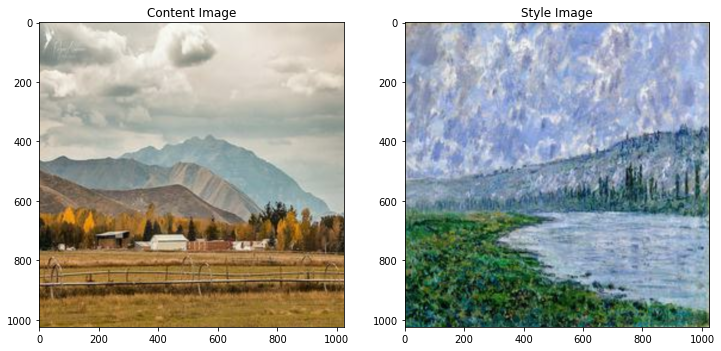

In [5]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title('Style Image')

plt.show()

In [14]:
# Creates a pre-trained VGG model which takes an input and returns a list of intermediate output values 
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [15]:

def gram_matrix(input_tensor):
  # Tensor contraction over specified indices and outer product.
  # Matrix multiplication
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  # Save the shape of the input tensor
  input_shape = tf.shape(input_tensor)
  # Casts a tensor to a new type.
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  # Divide matrix multiplication output to num_locations
  return result/(num_locations)

In [16]:
# We will use block5 conv2 layer for content 
content_layers = ['block5_conv2'] 
# We will use conv1 layers from every block for style 
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']


In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    # The main 
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

    # Used as keys in dict creation
    self.style_layers = style_layers
    self.content_layers = content_layers
    # self.num_style_layers = len(style_layers)
    

  def call(self, inputs):
    # Process the image input
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Feed the preprocessed image to the VGG19 model
    outputs = self.vgg(preprocessed_input)
    # Separate style and content outputs
    style_outputs, content_outputs = (outputs[:len(self.style_layers)], 
                                      outputs[len(self.style_layers):])
    # Process style output before dict creation
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]


    # Create two dicts for content and style outputs
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
extractor = StyleContentModel(style_layers, content_layers)
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:

# Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [19]:
total_variation_weight=500

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 
                                clip_value_min=0.0, 
                                clip_value_max=1.0))

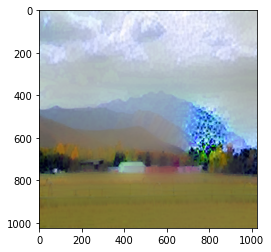

Train step: 2000


In [20]:
import IPython.display as display

image = tf.Variable(content_image)
epochs = 20
steps_per_epoch = 100
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  plt.imshow(image[0])
  plt.show()
  print("Train step: {}".format(step))

In [21]:
tf.keras.preprocessing.image.save_img('stylized-image.png', image[0])